In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Custom Dataset Class
class TrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.classes = 43

        for i in range(self.classes):
            path = os.path.join(root_dir, str(i))
            if not os.path.exists(path):
                print(f"Directory {path} not found!")
                continue
            images = os.listdir(path)

            for img_name in images:
                try:
                    image = Image.open(os.path.join(path, img_name)).convert('RGB')
                    if self.transform:
                        image = self.transform(image)
                    self.data.append(image)
                    self.labels.append(i)
                except Exception as e:
                    print(f"Error loading image {img_name}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [3]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor()
])
transform

Compose(
    Resize(size=(30, 30), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [4]:
# Dataset and DataLoader
train_dataset = TrafficSignDataset(root_dir='../archive/Train', transform=transform)
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_data, test_data = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [5]:
# Model Definition
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# Instantiate Model, Loss, Optimizer
model = TrafficSignNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training Loop
epochs = 2
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

Epoch 1, Loss: 0.7963302783100035
Epoch 2, Loss: 0.13217158314607153


In [8]:
# Khởi tạo mô hình trước
model = TrafficSignNet()

# Load state_dict vào mô hình
model.load_state_dict(torch.load("traffic_classifier.pth"))

# Chuyển mô hình sang chế độ đánh giá
model.eval()

TrafficSignNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)

In [9]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.988969650599337


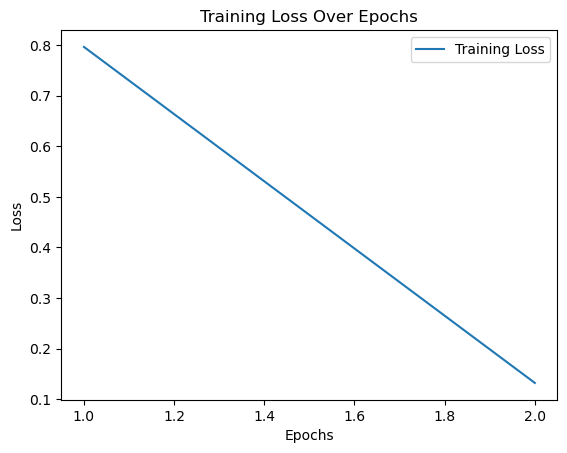

In [10]:
# Plotting Training Loss
plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Load CSV
test_csv = pd.read_csv('../archive/Test.csv')
labels = test_csv['ClassId'].values

In [12]:
# Load and transform test images
data = []
for img_path in test_csv['Path'].values:
    try:
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        data.append(img)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

if data:
    X_test = torch.stack(data)
    print("Loaded test images successfully!")
else:
    print("No valid test images loaded!")

Loaded test images successfully!


In [13]:
# Predict using the trained model
model.load_state_dict(torch.load("traffic_classifier.pth"))
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

final_accuracy = accuracy_score(labels, predicted.cpu().numpy())
print(f"Final Test Accuracy: {final_accuracy}")

Final Test Accuracy: 0.9531274742676168


In [15]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import ImageTk, Image
import torch
import torchvision.transforms as transforms
from BTL.backup.traffic_signs_pytorch import TrafficSignNet

# Load the trained PyTorch model
model = torch.load('traffic_classifier.pth', map_location=torch.device('cpu'))
model.eval()

# Dictionary to label all traffic sign classes
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

# Image preprocessing for PyTorch
transform = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize GUI
top = tk.Tk()
top.geometry('800x600')
top.title('Traffic sign classification')
top.configure(background='#CDCDCD')

label = Label(top, background='#CDCDCD', font=('arial', 15, 'bold'))
sign_image = Label(top)


def classify(file_path):
    try:
        # Load and preprocess the image
        image = Image.open(file_path).convert('RGB')
        image = transform(image)
        image = image.unsqueeze(0)  # Add batch dimension

        # Perform prediction
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            sign = classes.get(predicted.item(), "Unknown sign")

        print(sign)
        label.configure(foreground='#011638', text=sign)
    except Exception as e:
        print("Error during classification:", e)
        label.configure(foreground='#011638', text="Error during classification")


def show_classify_button(file_path):
    classify_b = Button(top, text="Classify Image", command=lambda: classify(file_path), padx=10, pady=5)
    classify_b.configure(background='#364156', foreground='white', font=('arial', 10, 'bold'))
    classify_b.place(relx=0.79, rely=0.46)


def upload_image():
    try:
        file_path = filedialog.askopenfilename()
        uploaded = Image.open(file_path)
        uploaded.thumbnail((top.winfo_width() / 2.25, top.winfo_height() / 2.25))
        im = ImageTk.PhotoImage(uploaded)

        sign_image.configure(image=im)
        sign_image.image = im
        label.configure(text='')
        show_classify_button(file_path)
    except Exception as e:
        print("Error during image upload:", e)


# Upload button
upload = Button(top, text="Upload an image", command=upload_image, padx=10, pady=5)
upload.configure(background='#364156', foreground='white', font=('arial', 10, 'bold'))
upload.pack(side=tk.BOTTOM, pady=50)

sign_image.pack(side=tk.BOTTOM, expand=True)
label.pack(side=tk.BOTTOM, expand=True)

heading = Label(top, text="Know Your Traffic Sign", pady=20, font=('arial', 20, 'bold'))
heading.configure(background='#CDCDCD', foreground='#364156')
heading.pack()

top.mainloop()


KeyboardInterrupt: 